In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(0)
tf.set_random_seed(0)

In [3]:
import input_data
mnist=input_data.read_data_sets('MNIST_data',one_hot=True)
n_samples=mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist.validation.num_examples

5000

In [5]:
def xavier_init(fan_in, fan_out, constant=1):
    low=-constant*np.sqrt(6.0/(fan_in+fan_out))
    high=constant*np.sqrt(6.0/(fan_in+fan_out))
    return tf.random_uniform((fan_in, fan_out),
                                                    minval=low, maxval=high,
                                                    dtype=tf.float32)

In [6]:
class VariationalAutoencoder(object):
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                            learning_rate=0.001, batch_size=100):
        self.network_architecture=network_architecture
        self.transfer_fct=transfer_fct
        self.learning_rate=learning_rate
        self.batch_size=batch_size
        
        self.x=tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        self._create_network()
        self._create_loss_optimizer()
        init=tf.global_variables_initializer()
        self.sess=tf.InteractiveSession()
        self.sess.run(init)
        
    def _create_network(self):
        network_weights=self._initialize_weights(**self.network_architecture)
        self.z_mean, self.z_log_sigma_sq=\
            self._recognition_network(network_weights["weights_recog"], network_weights["biases_recog"])
        n_z=self.network_architecture["n_z"]
        eps=tf.random_normal((self.batch_size, n_z), 0, 1,
                                                    dtype=tf.float32)
        self.z=tf.add(self.z_mean,
                                tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))#mul to multiply
        self.x_reconstr_mean=\
            self._generator_network(network_weights["weights_gener"],
                                                           network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2,
                                               n_hidden_gener_1, n_hidden_gener_2,
                                               n_input, n_z):
        all_weights=dict()
        all_weights["weights_recog"]={
            "h1": tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            "h2": tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            "out_mean":tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            "out_log_sigma":tf.Variable(xavier_init(n_hidden_recog_2,n_z))       
        }
        all_weights["biases_recog"]={
            "b1":tf.Variable(tf.zeros([n_hidden_recog_1],dtype=tf.float32)),
            "b2":tf.Variable(tf.zeros([n_hidden_recog_2],dtype=tf.float32)),
            "out_mean":tf.Variable(tf.zeros([n_z],dtype=tf.float32)),
            "out_log_sigma":tf.Variable(tf.zeros([n_z], dtype=tf.float32))
        }
        
        all_weights["weights_gener"]={
            "h1":tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            "h2":tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            "out_mean":tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            #"out_log_sigma":tf.Variable(xavier_init(n_hidden_gener_2, n_input))
        }
        all_weights["biases_gener"]={
            "b1":tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            "b2":tf.Variable(tf.zeros([n_hidden_gener_2],dtype=tf.float32)),
            "out_mean":tf.Variable(tf.zeros([n_input],dtype=tf.float32)),
            #"out_log_sigma":tf.Variable(tf.zeros([n_input],dtype=tf.float32))
        }
        
        return all_weights
    
    def _recognition_network(self,weights, biases):
        layer_1=self.transfer_fct(tf.add(tf.matmul(self.x, weights["h1"]), biases["b1"]))
        layer_2=self.transfer_fct(tf.add(tf.matmul(layer_1, weights["h2"]), biases["b2"]))
        z_mean=tf.add(tf.matmul(layer_2, weights["out_mean"]), biases["out_mean"])
        z_log_sigma_sq=tf.add(tf.matmul(layer_2, weights["out_log_sigma"]), biases["out_log_sigma"])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        layer_1=self.transfer_fct(tf.add(tf.matmul(self.z, weights["h1"]), biases["b1"]))
        layer_2=self.transfer_fct(tf.add(tf.matmul(layer_1,weights["h2"]),biases["b2"]))
        x_reconstr_mean=tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights["out_mean"]), biases["out_mean"]))
        return x_reconstr_mean
    
    def _create_loss_optimizer(self):
        reconstr_loss=-tf.reduce_sum(self.x*tf.log(1e-10+self.x_reconstr_mean)+(1-self.x)*tf.log(1e-10+1-self.x_reconstr_mean),1)
        latent_loss=-0.5*tf.reduce_sum(1+self.z_log_sigma_sq-tf.square(self.z_mean)-tf.exp(self.z_log_sigma_sq),1)
        self.cost=tf.reduce_mean(reconstr_loss+latent_loss)
        self.optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def  partial_fit(self, X):
        opt,cost=self.sess.run((self.optimizer, self.cost), feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x:X})
    
    def generate(self, z_mu=None):
        if z_mu is None:
            z_mu=np.random.normal(size=self.network_architecture["n_z"])
            return self.sess.run(self.x_reconstr_mean,feed_dict={self.z:z_mu})
        
    def reconstruct(self, X):
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.x: X})

In [7]:
def train(network_architecture, learning_rate=0.001, batch_size=100, training_epochs=10, display_step=5):
    vae=VariationalAutoencoder(network_architecture, learning_rate=learning_rate, batch_size=batch_size)
    
    for epoch in range(training_epochs):
        avg_cost=0.
        total_batch=int(n_samples/batch_size)
        for i in range(total_batch):
            batch_xs, _ =mnist.train.next_batch(batch_size)
            cost=vae.partial_fit(batch_xs)
            avg_cost+=cost/n_samples*batch_size
            
        if epoch % display_step==0:
            print("Epoch:", "%04d"%(epoch+1),
                     "cost=","{:.9f}".format(avg_cost))
            
    return vae         

In [8]:
network_architecture=\
    dict(n_hidden_recog_1=500,
            n_hidden_recog_2=500,
            n_hidden_gener_1=500,
            n_hidden_gener_2=500,
            n_input=784,
            n_z=20)
    
vae=train(network_architecture, training_epochs=75)

Epoch: 0001 cost= 174.678878673
Epoch: 0006 cost= 108.714620278
Epoch: 0011 cost= 103.560559373
Epoch: 0016 cost= 101.136302310
Epoch: 0021 cost= 99.588368558
Epoch: 0026 cost= 98.515359344
Epoch: 0031 cost= 97.750770402
Epoch: 0036 cost= 97.064341888
Epoch: 0041 cost= 96.590453699
Epoch: 0046 cost= 96.198475009
Epoch: 0051 cost= 95.800051297
Epoch: 0056 cost= 95.439631861
Epoch: 0061 cost= 95.155129616
Epoch: 0066 cost= 94.864634344
Epoch: 0071 cost= 94.598342257


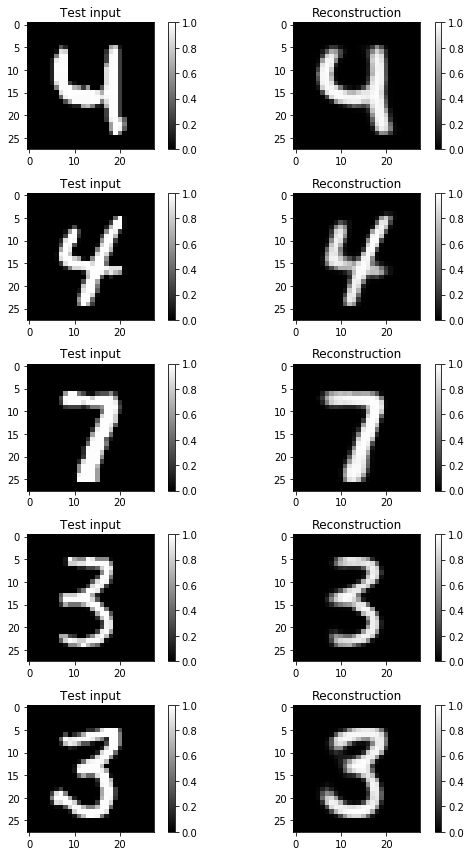

In [9]:
x_sample=mnist.test.next_batch(100)[0]
x_reconstruct=vae.reconstruct(x_sample)

plt.figure(figsize=(8,12))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(x_sample[i].reshape(28,28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5,2,2*i+2)
    plt.imshow(x_reconstruct[i].reshape(28,28),vmin=0,vmax=1,cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

In [10]:
network_architecture=\
    dict(n_hidden_recog_1=500,
            n_hidden_recog_2=500,
            n_hidden_gener_1=500,
            n_hidden_gener_2=500,
            n_input=784,
            n_z=2)
vae_2d=train(network_architecture,training_epochs=75)

Epoch: 0001 cost= 190.964296875
Epoch: 0006 cost= 153.596175371
Epoch: 0011 cost= 148.406473028
Epoch: 0016 cost= 145.892791804
Epoch: 0021 cost= 144.297089761
Epoch: 0026 cost= nan
Epoch: 0031 cost= nan
Epoch: 0036 cost= nan
Epoch: 0041 cost= nan


KeyboardInterrupt: 

In [ ]:
x_sample,y_sample=mnist.test.next_batch(5000)
z_mu=vae_2d.transform(x_sample)
plt.figure(figsize=(8,6))
plt.scatter(z_mu[:,0],z_mu[:,1], c=np.argmax(y_sample,1))
plt.colorbar()
plt.grid()

In [ ]:
nx=ny=20
x_values=np.linspace(-3,3,nx)
y_values=np.linspace(-3,3,ny)

canvas=np.empty((28*ny,28*nx))
for i, yi in enumerate(x_values):
    for j,xi in enumerate(y_values):
        z_mu=np.array([[xi,yi]]*vae.batch_size)
        x_mean=vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28]=x_mean[0].reshape(28,28)
        
plt.figure(figsize=(8,10))
Xi, Yi=np.meshgrid(x_values,y_values)
plt.imshow(canvas, origin=upper,cmap="gray")
plt.tight_layout()